In [ ]:
!pip install catboost
!pip install category_encoders
!pip install imbalanced-ensemble
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.5/746.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
uploaded = files.upload()

Mounted at /content/drive


Saving crash_severity.csv to crash_severity.csv


In [ ]:
import itertools

# data preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# encoders

import category_encoders as ce

# normalization and imputation

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# samplers

from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, InstanceHardnessThreshold, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection, TomekLinks, ClusterCentroids
from imbens.sampler._under_sampling import SelfPacedUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, SMOTEN, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

# classifiers


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# metric and hyperparameters tuning

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, recall_score, confusion_matrix

# pipeline

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', None)

#**1) Data:**

In [ ]:
br = pd.read_csv('crash_severity.csv', low_memory=False)

In [ ]:
br['SEVERITY_CD'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4}, inplace = True)

In [ ]:
br.loc[(br['DR_AGE'] <= 18) | (br['DR_AGE'] >= 100), 'DR_AGE'] = np.nan

In [ ]:
columns_ML = ['ROAD_COND_CD', 'ROAD_TYPE_CD', 'SURF_COND_CD', 'SURF_TYPE_CD', 'PAVEMENT_TYPE',
              'SHOULDER_TYPE_PRI', 'PRI_ROAD_TYPE', 'ROAD_REL_CD', 'ALIGNMENT_CD', 'ACCESS_CNTL_CD',
              'INTERSECTION', 'VEH_COND_CD', 'VEH_LIGHTING_CD', 'VEH_TYPE_CD', 'DR_SEX',
              'ALCOHOL', 'DRUGS', 'LIGHTING_CD', 'WEATHER_CD', 'PEDESTRIAN', 'TRAFF_CNTL_CD',
              'TRAFF_CNTL_COND_CD', 'VIOLATIONS_CD', 'VISION_OBSCURE_CD', 'MAN_COLL_CD', 'SEVERITY_CD',
              'DR_AGE', 'CAR_AGE', 'LATITUDE','LONGITUDE']

br_ML = br[columns_ML]

In [ ]:
numeric_features = ['DR_AGE', 'CAR_AGE', 'LATITUDE', 'LONGITUDE']
categorical_features = ['ROAD_COND_CD', 'ROAD_TYPE_CD', 'SURF_COND_CD', 'SURF_TYPE_CD', 'PAVEMENT_TYPE',
                        'SHOULDER_TYPE_PRI', 'PRI_ROAD_TYPE', 'ROAD_REL_CD', 'ALIGNMENT_CD', 'ACCESS_CNTL_CD',
                        'INTERSECTION', 'VEH_COND_CD', 'VEH_LIGHTING_CD', 'VEH_TYPE_CD', 'DR_SEX',
                        'ALCOHOL', 'DRUGS', 'LIGHTING_CD', 'WEATHER_CD', 'PEDESTRIAN', 'TRAFF_CNTL_CD',
                        'TRAFF_CNTL_COND_CD', 'VIOLATIONS_CD', 'VISION_OBSCURE_CD', 'MAN_COLL_CD']

In [ ]:
X = br_ML.drop(columns = 'SEVERITY_CD')
y = br_ML['SEVERITY_CD']

In [ ]:
bool_features = X.select_dtypes(include=['bool']).columns
X[bool_features] = X[bool_features].astype('object')

In [ ]:
X['INTERSECTION'] = X['INTERSECTION'].astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

#**2) Functions:**

In [ ]:
def pipe(numeric_features, categorical_features, encoder, sampler, classifier):

  '''This functions make pipeline given the encoder, sampler and classifer'''

  numeric_transformer = Pipeline(
  steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
  )

  categorical_transformer = Pipeline(
  steps=[("imputer", SimpleImputer(strategy="constant")), ("encoder", encoder)]
  )

  preprocessor = ColumnTransformer(
      transformers=[
          ("numerical", numeric_transformer, numeric_features),
          ("categorical", categorical_transformer, categorical_features),
      ]
  )

  if sampler == None:

    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', classifier)])

  else:

      pipeline = Pipeline([('preprocessor', preprocessor), ('sampler', sampler), ('classifier', classifier)])

  return  pipeline



def plot_confusion_matrix(cm):

  '''
  This function plot the confusion matrix given the ture lable and predicted label by the model'''

  figsize = (8, 8)
  fig, ax = plt.subplots(figsize=figsize)
  cm_norm = cm.astype("float")*100 / cm.sum(axis=1)[:, np.newaxis]
  cax = ax.matshow(cm_norm, cmap=plt.cm.Blues)
  cbar = fig.colorbar(cax, norm=colors.Normalize(vmin=0, vmax=100))


  ax.set(title="Confusion Matrix",
          xlabel="Predicted label",
          ylabel="True label")

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ax.xaxis.label.set_size(10)
  ax.yaxis.label.set_size(10)
  ax.title.set_size(10)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=10)



def model(numeric_features, categorical_features, encoder, sampler, classifier, param_grid):

  pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
  gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
  gcv.fit(X_train, y_train)
  best_estimator = gcv.best_estimator_
  y_pred_train = best_estimator.predict(X_train)
  y_pred_test = best_estimator.predict(X_test)
  recall_train = recall_score(y_train, y_pred_train, average='macro', labels= y_train.unique())
  recall_test = recall_score(y_test, y_pred_test, average='macro', labels= y_test.unique())
  cm_train = confusion_matrix(y_train, y_pred_train)
  cm_test = confusion_matrix(y_test, y_pred_test)
  best_params = gcv.best_params_

  return recall_train, recall_test, cm_train, cm_test, best_params

#**3) Encoders/Samplers/Classifiers:**

In [ ]:
classifiers = {
    'LogisticRegression': LogisticRegression(class_weight= 'balanced', random_state = 42),
    #'LogisticRegression_bagging' : BaggingClassifier(LogisticRegression(random_state = 42)),
   # 'LogisticRegression_boosting' : AdaBoostClassifier(LogisticRegression(random_state = 42)),
    'LogisticRegression': DecisionTreeClassifier(class_weight= 'balanced', random_state = 42),
   # 'LogisticRegression_bagging' : BaggingClassifier(LogisticRegression(random_state = 42)),
   #'LogisticRegression_boosting' : AdaBoostClassifier(LogisticRegression(random_state = 42))
}

encoders = {
    'OneHotEncoder': ce.one_hot.OneHotEncoder(),
    'BinaryEncoder': ce.binary.BinaryEncoder(),
    'TargetEncoder': ce.target_encoder.TargetEncoder(),
    'CatBoostEncoder' : ce.cat_boost.CatBoostEncoder(),
    'CountEncoder' : ce.count.CountEncoder(),
    'Gray': ce.gray.GrayEncoder(),
    'HashingEncoder' : ce.hashing.HashingEncoder(),
    'HelmertEncoder' : ce.helmert.HelmertEncoder(),
    'JamesSteinEncoder' : ce.james_stein.JamesSteinEncoder(),
    'LeaveOneOutEncoder' : ce.leave_one_out.LeaveOneOutEncoder(),
    'MEstimateEncoder' : ce.m_estimate.MEstimateEncoder(),
    'OrdinalEncoder' : ce.ordinal.OrdinalEncoder(),
    'PolynomialEncoder' : ce.polynomial.PolynomialEncoder(),
    'QuantileEncoder' : ce.quantile_encoder.QuantileEncoder(),
    'RankHotEncoder' : ce.rankhot.RankHotEncoder(),
    'SumEncoder' : ce.sum_coding.SumEncoder(),
    'SummaryEncoder' : ce.quantile_encoder.SummaryEncoder(),
    'BackwardDifferenceEncoder' : ce.backward_difference.BackwardDifferenceEncoder()
}

samplers = {
    #'None': None
    'RandomUnderSampler': RandomUnderSampler(random_state=0),
    #'TomekLinks': TomekLinks(),
    #!!! 'EditedNearestNeighbours': EditedNearestNeighbours(),
    #!!! 'RepeatedEditedNearestNeighbours': RepeatedEditedNearestNeighbours(),
    #'AllKNN': AllKNN(),
    #!!!'CondensedNearestNeighbour': CondensedNearestNeighbour(random_state=0),
    #'OneSidedSelection': OneSidedSelection(random_state=0),
    #'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule(),
    #'InstanceHardnessThreshold': InstanceHardnessThreshold(random_state=0),
    #'ClusterCentroids': ClusterCentroids(random_state=0),
    #'NearMiss': NearMiss(),
    #!!! 'BalanceCascadeUnderSampler': BalanceCascadeUnderSampler(random_state=0),
    #!!! 'SelfPacedUnderSampler': SelfPacedUnderSampler(random_state=0),
    'RandomOverSampler': RandomOverSampler(random_state=0),
    'SMOTE': SMOTE(random_state=0),
    'ADASYN': ADASYN(random_state=0),
    #'BorderlineSMOTE': BorderlineSMOTE(random_state=0),
    #'SVMSMOTE': SVMSMOTE(random_state=0),
    #'KMeansSMOTE': KMeansSMOTE(random_state=0),
    #'SMOTEN': SMOTEN(random_state=0),
    #'SMOTETomek': SMOTETomek(random_state=0),
    'SMOTEENN': SMOTEENN(random_state=0)
}

#**4) Models:**

### **4.1) Logistic Regression:**

In [ ]:
sampler = None
classifier = LogisticRegression(class_weight='balanced', random_state=42)
param_grid = {
    'classifier__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5, 10, 50, 100, 500, 1000]
}
recall_train_encoders = []
recall_test_encoders = []
best_params_encoders = []

for encoder in encoders.values():

  recall_train, recall_test, cm_train, cm_test, best_params = model(numeric_features, categorical_features, encoder, sampler, classifier, param_grid)

  recall_train_encoders.append(recall_train)
  recall_test_encoders.append(recall_test)
  best_params_encoders.append(best_params['classifier__C'])

results_lr_encoders = pd.DataFrame({'encoder':list(encoders.keys()), 'recall_train': recall_train_encoders, 'recall_test': recall_test_encoders, 'C': best_params_encoders})

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each

In [ ]:
results_lr_encoders

,encoder,recall_train,recall_test,C
0,OneHotEncoder,0.470139,0.453105,0.005
1,BinaryEncoder,0.447845,0.412363,0.005
2,TargetEncoder,0.391282,0.431710,5.000
3,CatBoostEncoder,0.401246,0.417673,10.000
4,CountEncoder,0.375380,0.400842,0.010
5,Gray,0.437503,0.392235,0.010
6,HashingEncoder,0.308755,0.296104,50.000
7,HelmertEncoder,0.500633,0.451263,0.001
8,JamesSteinEncoder,0.366665,0.404021,50.000
9,LeaveOneOutEncoder,0.397374,0.410331,5.000


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'OneHotEncoder'),
  Text(1, 0, 'BinaryEncoder'),
  Text(2, 0, 'TargetEncoder'),
  Text(3, 0, 'CatBoostEncoder'),
  Text(4, 0, 'CountEncoder'),
  Text(5, 0, 'Gray'),
  Text(6, 0, 'HashingEncoder'),
  Text(7, 0, 'HelmertEncoder'),
  Text(8, 0, 'JamesSteinEncoder'),
  Text(9, 0, 'LeaveOneOutEncoder'),
  Text(10, 0, 'MEstimateEncoder'),
  Text(11, 0, 'OrdinalEncoder'),
  Text(12, 0, 'PolynomialEncoder'),
  Text(13, 0, 'QuantileEncoder'),
  Text(14, 0, 'RankHotEncoder'),
  Text(15, 0, 'SumEncoder'),
  Text(16, 0, 'SummaryEncoder'),
  Text(17, 0, 'BackwardDifferenceEncoder')])

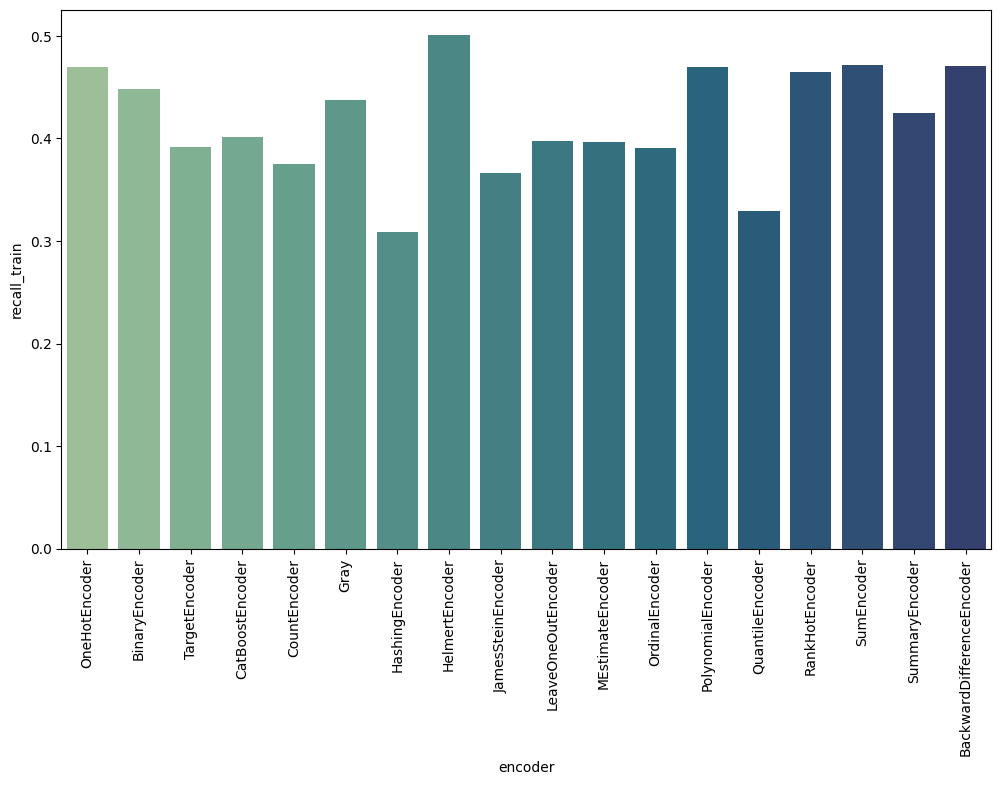

In [ ]:
plt.figure(figsize = (12, 7))
sns.barplot(results_lr_encoders, x="encoder", y='recall_train', palette='crest')
plt.xticks(rotation=90)

Text(0, 0.5, 'recall (test set)')

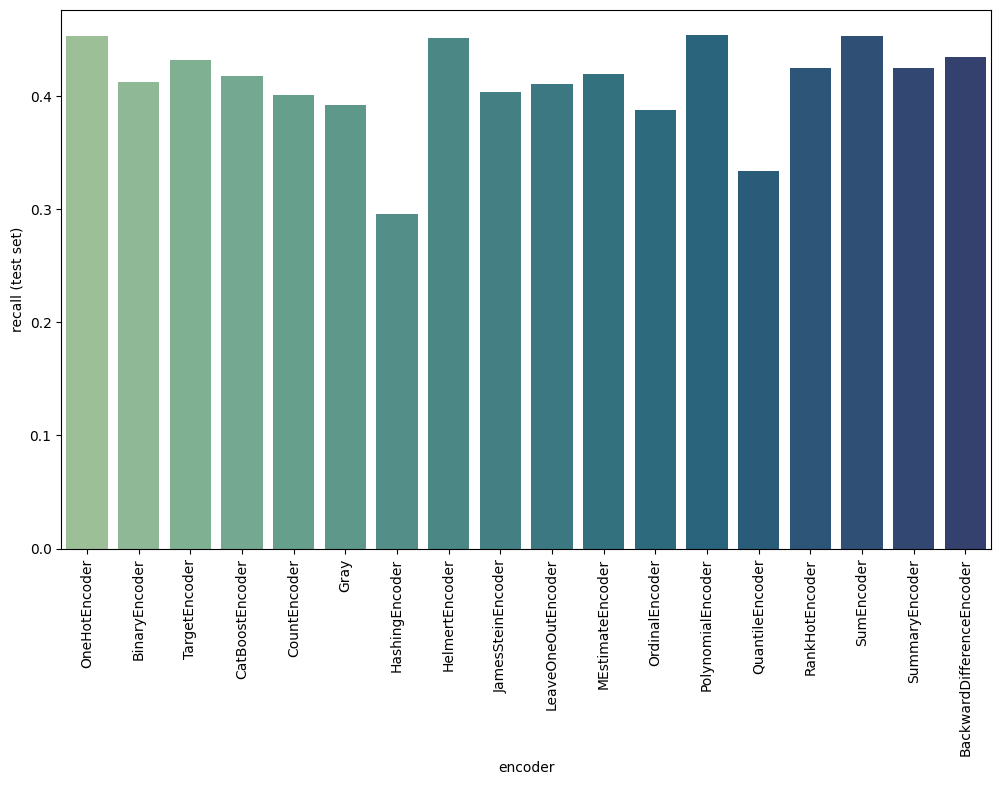

In [ ]:
plt.figure(figsize = (12, 7))
sns.barplot(results_lr_encoders, x="encoder", y='recall_test', palette='crest')
plt.xticks(rotation=90)
plt.ylabel('recall (test set)')

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
classifier = LogisticRegression(random_state=42)
param_grid = {
    'classifier__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5, 10, 50, 100, 500, 1000]
}
recall_train_samplers = []
recall_test_samplers = []
best_params_samplers = []

for sampler in samplers.values():

  recall_train, recall_test, cm_train, cm_test, best_params = model(numeric_features, categorical_features, encoder, sampler, classifier, param_grid)

  recall_train_samplers.append(recall_train)
  recall_test_samplers.append(recall_test)
  best_params_samplers.append(best_params['classifier__C'])

results_lr_samplers = pd.DataFrame({'encoder':list(samplers.keys()), 'recall_train': recall_train_samplers, 'recall_test': recall_test_samplers, 'C': best_params_samplers})

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits


In [ ]:
results_lr_samplers

,encoder,recall_train,recall_test,C
0,RandomUnderSampler,0.379574,0.365772,0.001
1,RandomOverSampler,0.470945,0.450804,0.001
2,SMOTE,0.469271,0.448997,0.001
3,ADASYN,0.462103,0.452174,0.001
4,SMOTEENN,0.465258,0.430474,0.001


In [ ]:
encoder = ce.target_encoder.TargetEncoder() #ce.quantile_encoder.SummaryEncoder()#ce.helmert.HelmertEncoder() #ce.polynomial.PolynomialEncoder() #ce.sum_coding.SumEncoder() #ce.one_hot.OneHotEncoder()
sampler = None
classifier = LogisticRegression(class_weight='balanced', random_state=42)
param_grid = {
    'classifier__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5, 10, 50, 100, 500, 1000]
}
recall_train_lr, recall_test_lr, cm_train_lr, cm_test_lr, best_params_lr = model(numeric_features, categorical_features, encoder, sampler, classifier, param_grid)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


In [ ]:
recall_train_lr, recall_test_lr, best_params_lr

(0.39128168890121157, 0.4317104835614938, {'classifier__C': 5})

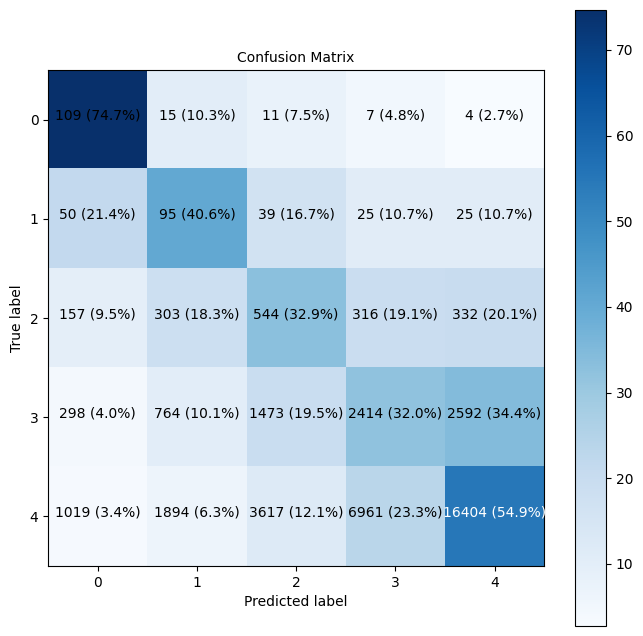

In [ ]:
plot_confusion_matrix(cm_train_lr)

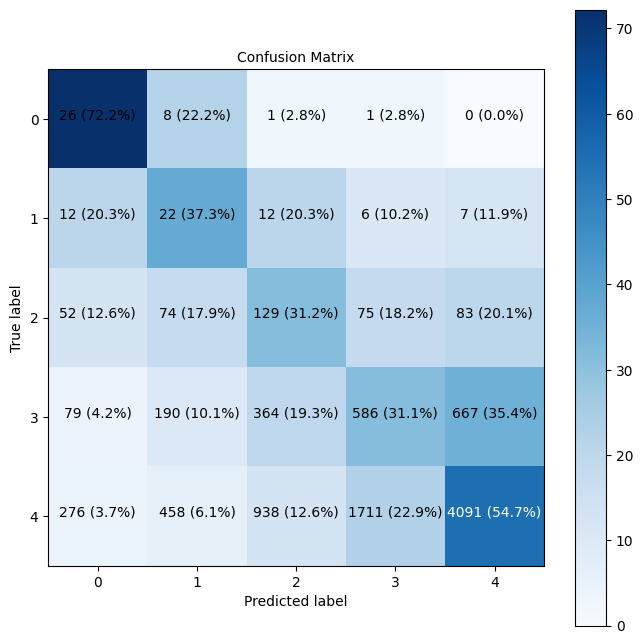

In [ ]:
plot_confusion_matrix(cm_test_lr)

### **4.2) KNN:**


In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = None
classifier = KNeighborsClassifier()
param_grid = {
    'classifier__n_neighbors': [1],
    #'classifier__penalty': ['elasticnet'],
    #'classifier__solver': ['saga'],
    #'classifier__l1_ratio': [0.0, 0.3, 0.5, 0.7, 1.0]
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_knn = best_estimator.predict(X_train)
y_pred_test_knn = best_estimator.predict(X_test)
recall_train_knn = recall_score(y_train, y_pred_train_knn, average='macro')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_knn, recall_test_knn

(0.9998789346246972, 0.25217348528264033)

In [ ]:
cm_train_knn = confusion_matrix(y_train, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

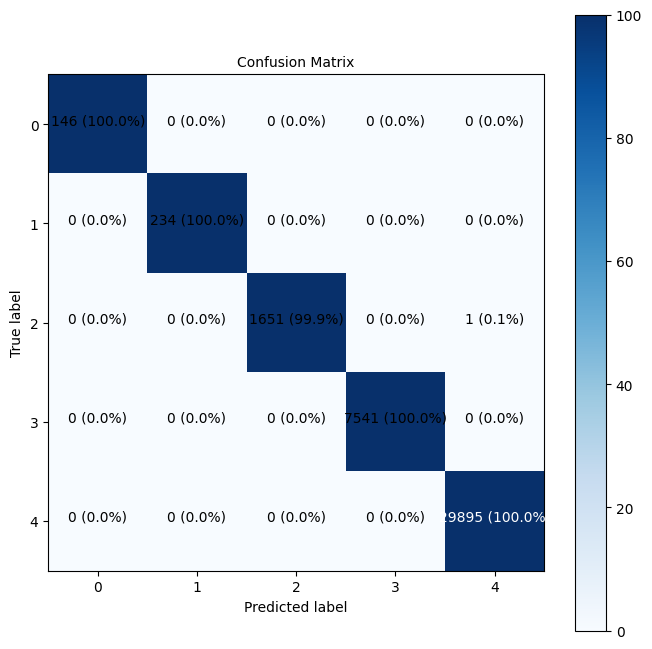

In [ ]:
plot_confusion_matrix(cm_train_knn)

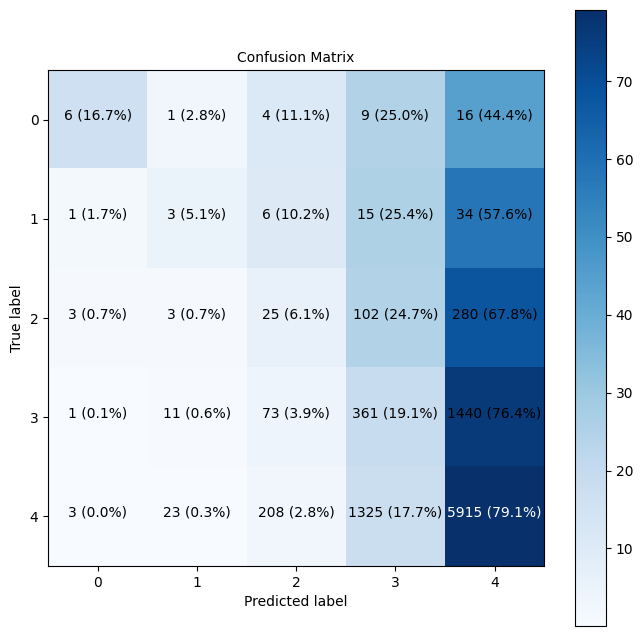

In [ ]:
plot_confusion_matrix(cm_test_knn)

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = None
classifier = KNeighborsClassifier()
param_grid = {
    'classifier__n_neighbors': [10],
    #'classifier__penalty': ['elasticnet'],
    #'classifier__solver': ['saga'],
    #'classifier__l1_ratio': [0.0, 0.3, 0.5, 0.7, 1.0]
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_knn = best_estimator.predict(X_train)
y_pred_test_knn = best_estimator.predict(X_test)
recall_train_knn = recall_score(y_train, y_pred_train_knn, average='macro')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_knn, recall_test_knn

(0.8545965238942761, 0.27543489101164853)

In [ ]:
cm_train_knn = confusion_matrix(y_train, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

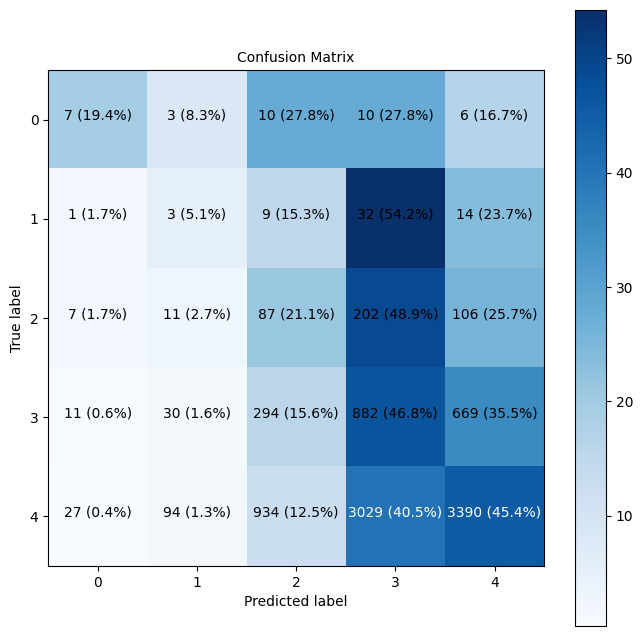

In [ ]:
plot_confusion_matrix(cm_test_knn)

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = RandomOverSampler(random_state=42)
classifier = KNeighborsClassifier()
param_grid = {
    'classifier__n_neighbors': [20],
    #'classifier__penalty': ['elasticnet'],
    #'classifier__solver': ['saga'],
    #'classifier__l1_ratio': [0.0, 0.3, 0.5, 0.7, 1.0]
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_knn = best_estimator.predict(X_train)
y_pred_test_knn = best_estimator.predict(X_test)
recall_train_knn = recall_score(y_train, y_pred_train_knn, average='macro')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_knn, recall_test_knn

(0.8092694544604715, 0.2923150091607509)

In [ ]:
cm_train_knn = confusion_matrix(y_train, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

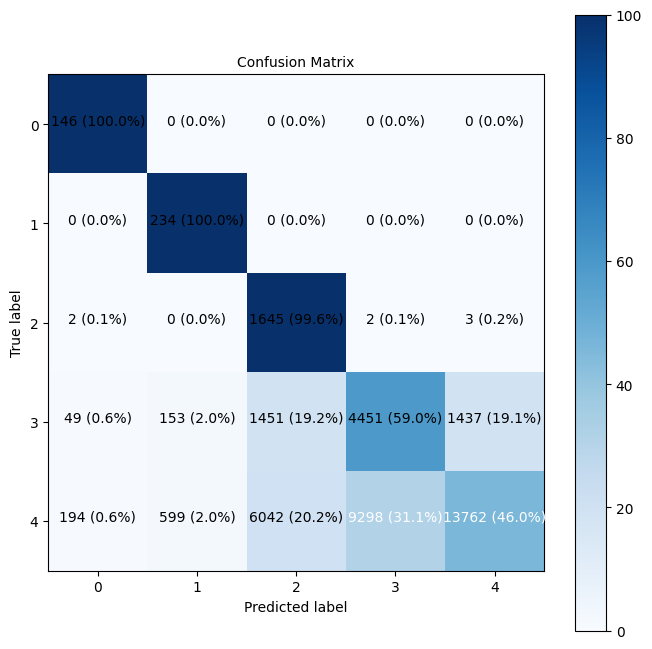

In [ ]:
plot_confusion_matrix(cm_train_knn)

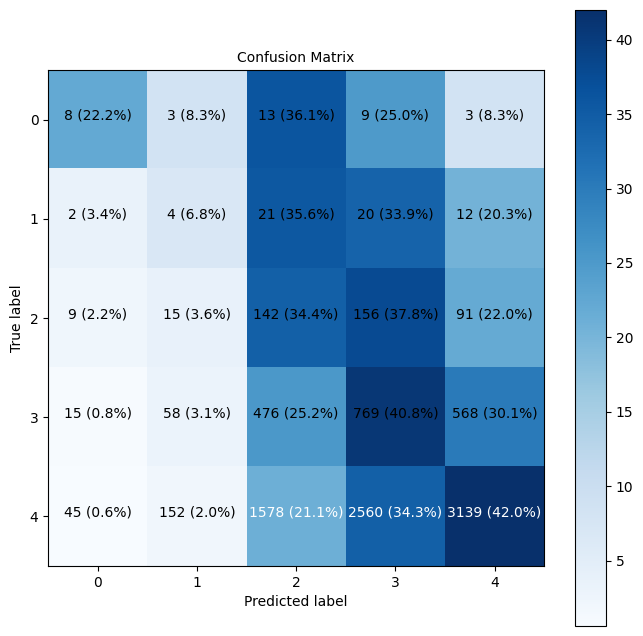

In [ ]:
plot_confusion_matrix(cm_test_knn)

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = RandomOverSampler(random_state=42)
classifier = KNeighborsClassifier()
param_grid = {
    'classifier__n_neighbors': [50],
    #'classifier__penalty': ['elasticnet'],
    #'classifier__solver': ['saga'],
    #'classifier__l1_ratio': [0.0, 0.3, 0.5, 0.7, 1.0]
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_knn = best_estimator.predict(X_train)
y_pred_test_knn = best_estimator.predict(X_test)
recall_train_knn = recall_score(y_train, y_pred_train_knn, average='macro')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_knn, recall_test_knn

(0.7203941452117684, 0.30516924646513244)

In [ ]:
cm_train_knn = confusion_matrix(y_train, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

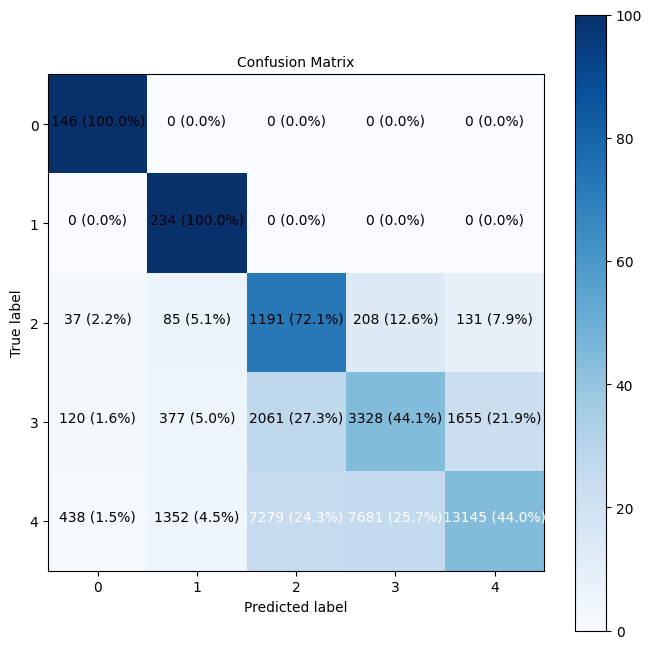

In [ ]:
plot_confusion_matrix(cm_train_knn)

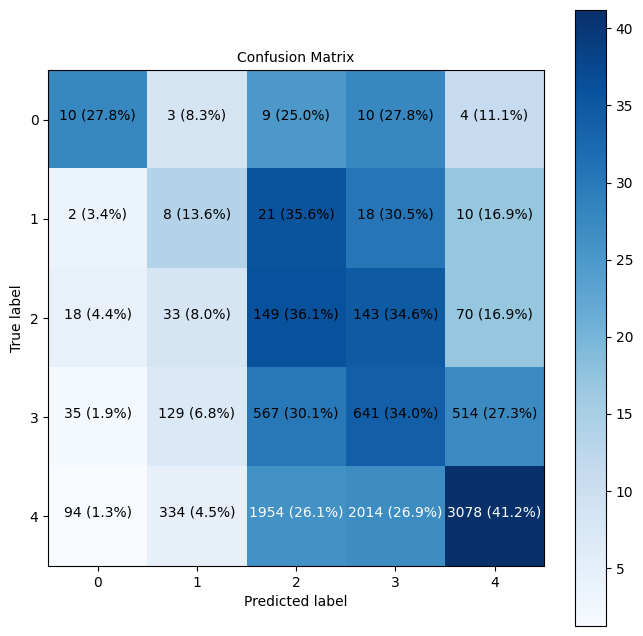

In [ ]:
plot_confusion_matrix(cm_test_knn)

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = RandomOverSampler(random_state=42)
classifier = KNeighborsClassifier()
param_grid = {
    'classifier__n_neighbors': [100],
    #'classifier__penalty': ['elasticnet'],
    #'classifier__solver': ['saga'],
    #'classifier__l1_ratio': [0.0, 0.3, 0.5, 0.7, 1.0]
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_knn = best_estimator.predict(X_train)
y_pred_test_knn = best_estimator.predict(X_test)
recall_train_knn = recall_score(y_train, y_pred_train_knn, average='macro')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_knn, recall_test_knn

(0.6755275684500411, 0.3513135543667615)

In [ ]:
cm_train_knn = confusion_matrix(y_train, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

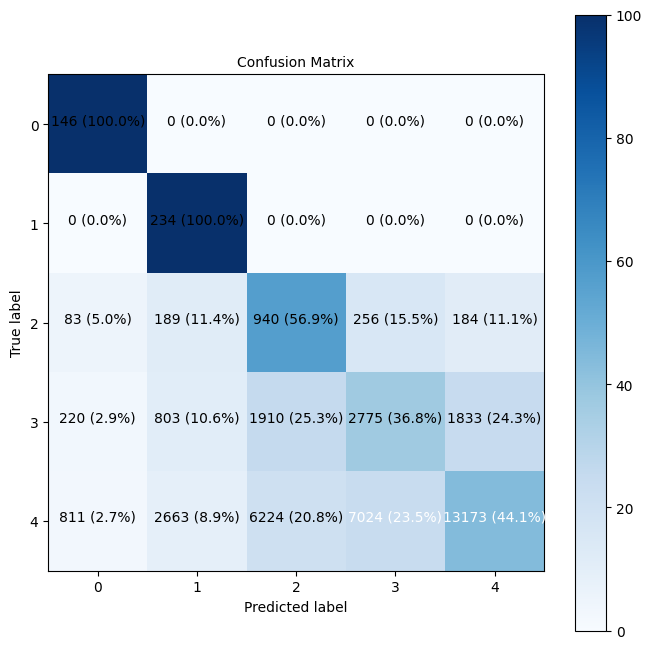

In [ ]:
plot_confusion_matrix(cm_train_knn)

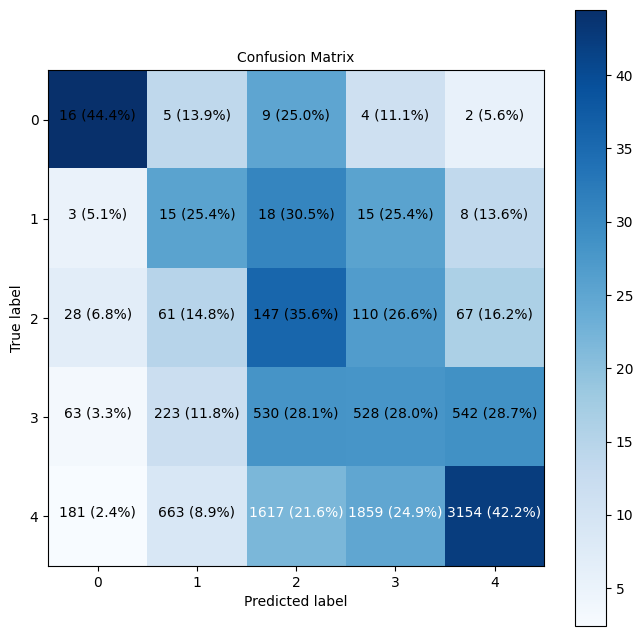

In [ ]:
plot_confusion_matrix(cm_test_knn)

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = RandomOverSampler(random_state=42)
classifier = KNeighborsClassifier()
param_grid = {
    'classifier__n_neighbors': [500],
    #'classifier__penalty': ['elasticnet'],
    #'classifier__solver': ['saga'],
    #'classifier__l1_ratio': [0.0, 0.3, 0.5, 0.7, 1.0]
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_knn = best_estimator.predict(X_train)
y_pred_test_knn = best_estimator.predict(X_test)
recall_train_knn = recall_score(y_train, y_pred_train_knn, average='macro')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_knn, recall_test_knn

(0.509486660433514, 0.36646487795586874)

In [ ]:
cm_train_knn = confusion_matrix(y_train, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

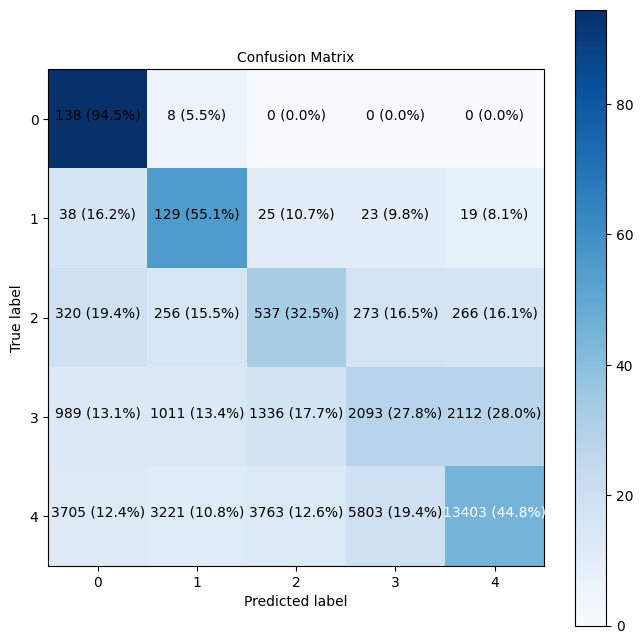

In [ ]:
plot_confusion_matrix(cm_train_knn)

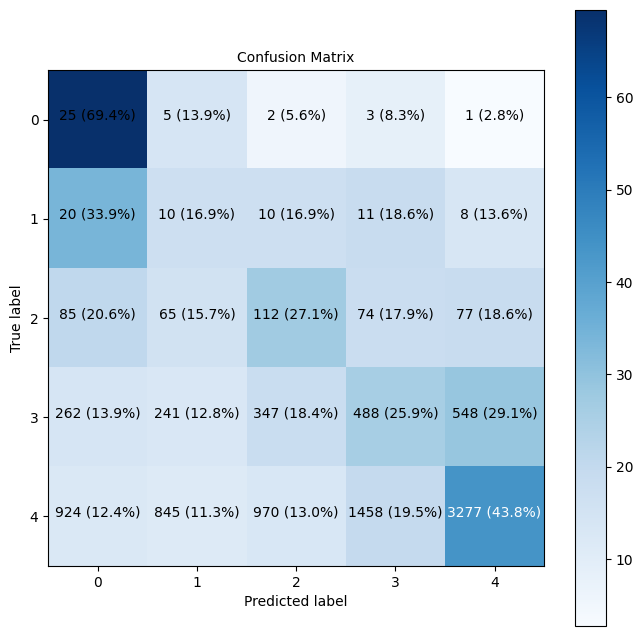

In [ ]:
plot_confusion_matrix(cm_test_knn)

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = RandomOverSampler(random_state=42)
classifier = KNeighborsClassifier()
param_grid = {
    'classifier__n_neighbors': [1000],
    #'classifier__penalty': ['elasticnet'],
    #'classifier__solver': ['saga'],
    #'classifier__l1_ratio': [0.0, 0.3, 0.5, 0.7, 1.0]
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_knn = best_estimator.predict(X_train)
y_pred_test_knn = best_estimator.predict(X_test)
recall_train_knn = recall_score(y_train, y_pred_train_knn, average='macro')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_knn, recall_test_knn

(0.4566199052164285, 0.3780418107329894)

In [ ]:
recall_train_knn, recall_test_knn

(0.4566199052164285, 0.3780418107329894)

In [ ]:
cm_train_knn = confusion_matrix(y_train, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

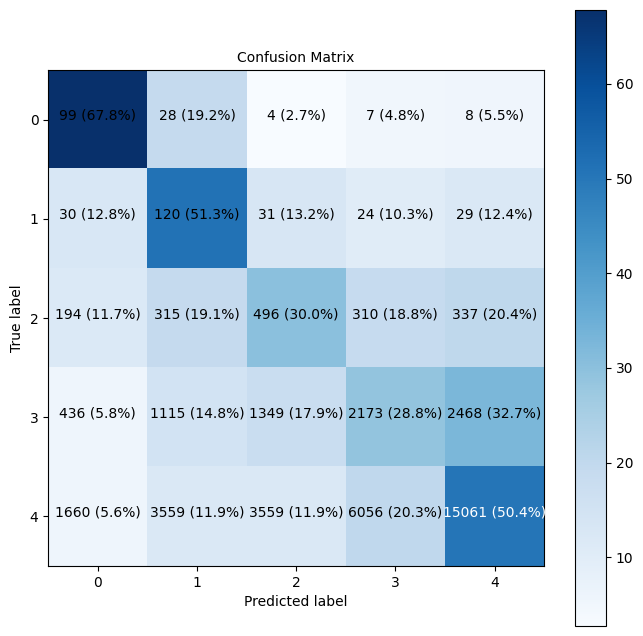

In [ ]:
plot_confusion_matrix(cm_train_knn)

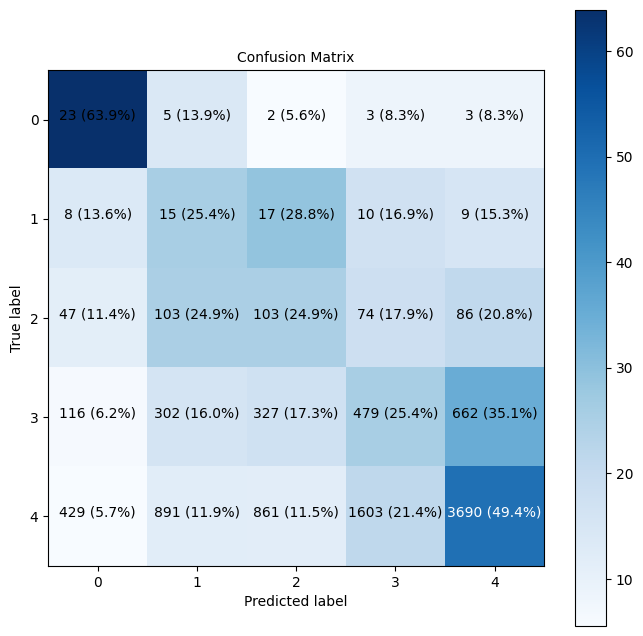

In [ ]:
plot_confusion_matrix(cm_test_knn)

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = RandomOverSampler(random_state=42)
classifier = KNeighborsClassifier()
param_grid = {
    'classifier__n_neighbors': [1500],
    #'classifier__penalty': ['elasticnet'],
    #'classifier__solver': ['saga'],
    #'classifier__l1_ratio': [0.0, 0.3, 0.5, 0.7, 1.0]
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_knn = best_estimator.predict(X_train)
y_pred_test_knn = best_estimator.predict(X_test)
recall_train_knn = recall_score(y_train, y_pred_train_knn, average='macro')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_knn, recall_test_knn

(0.4426837764262121, 0.36812671742457936)

In [ ]:
cm_train_knn = confusion_matrix(y_train, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

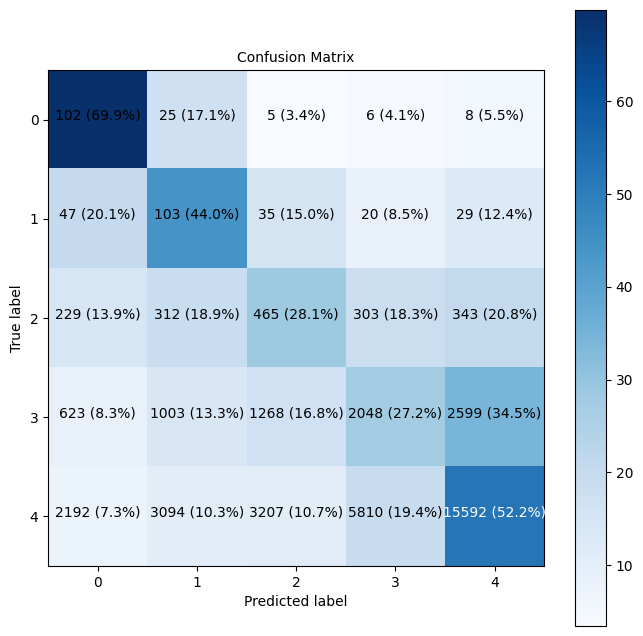

In [ ]:
plot_confusion_matrix(cm_train_knn)

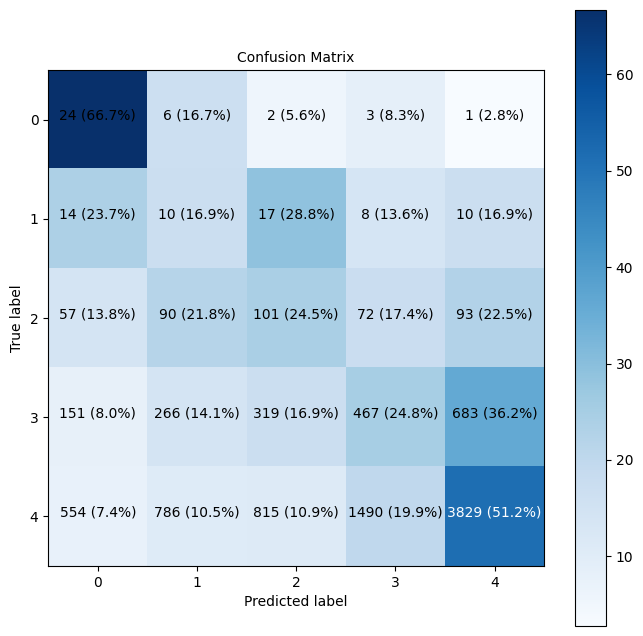

In [ ]:
plot_confusion_matrix(cm_test_knn)

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = RandomOverSampler(random_state=42)
classifier = KNeighborsClassifier()
param_grid = {
    'classifier__n_neighbors': [10000],
    #'classifier__penalty': ['elasticnet'],
    #'classifier__solver': ['saga'],
    #'classifier__l1_ratio': [0.0, 0.3, 0.5, 0.7, 1.0]
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_knn = best_estimator.predict(X_train)
y_pred_test_knn = best_estimator.predict(X_test)
recall_train_knn = recall_score(y_train, y_pred_train_knn, average='macro')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_knn, recall_test_knn

(0.37525198671823495, 0.3780383818555225)

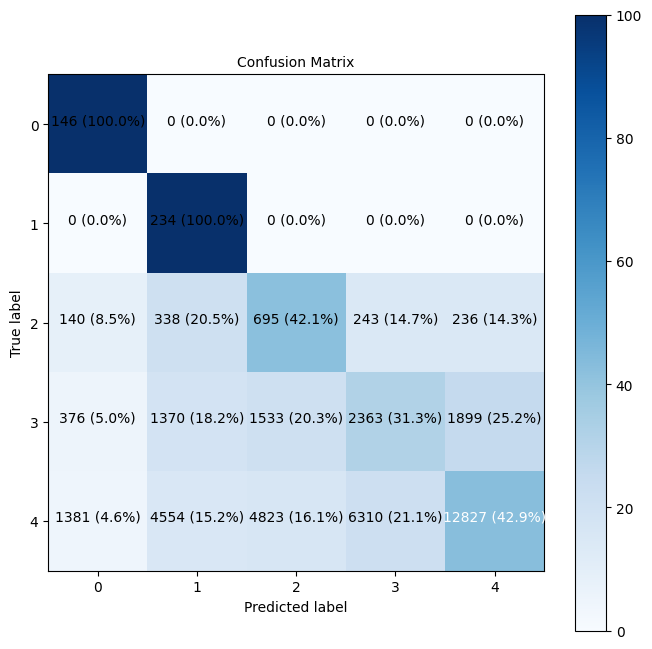

In [ ]:
plot_confusion_matrix(cm_train_knn)

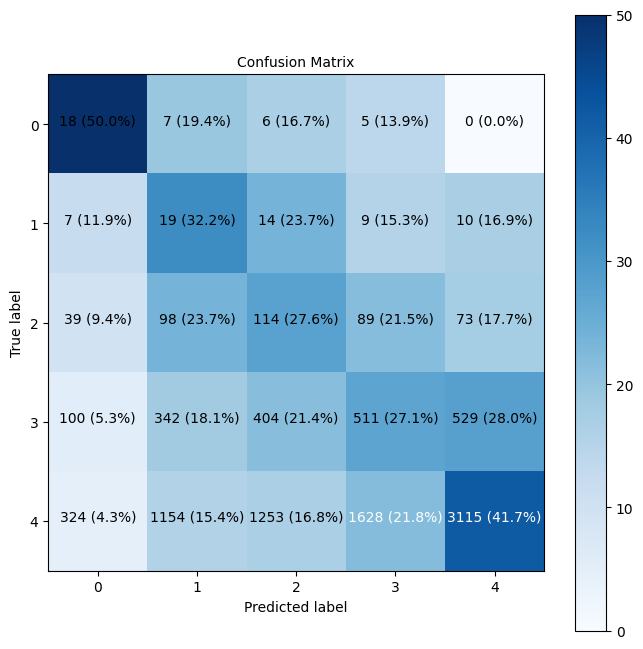

In [ ]:
plot_confusion_matrix(cm_test_knn)

### **4.3) Decision Tree:**

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = None
classifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)
param_grid = {
    'classifier__criterion': ['entropy'],
    'classifier__max_depth': [15],
    'classifier__min_samples_split': [6],
    'classifier__min_samples_leaf': [5],
    'classifier__max_features': ['log2']
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_dt = best_estimator.predict(X_train)
y_pred_test_dt = best_estimator.predict(X_test)
recall_train_dt = recall_score(y_train, y_pred_train_dt, average='macro')
recall_test_dt = recall_score(y_test, y_pred_test_dt, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_dt, recall_test_dt

(0.45804351598022447, 0.3726380880169219)

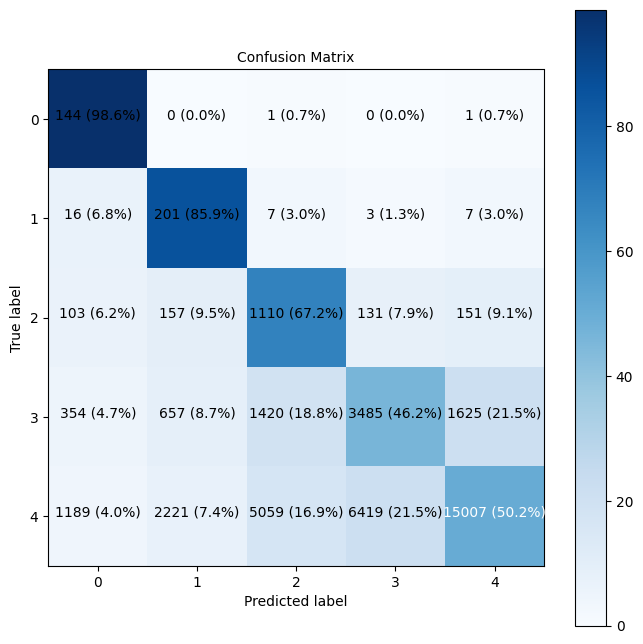

In [ ]:
plot_confusion_matrix(y_train, y_pred_train_dt)

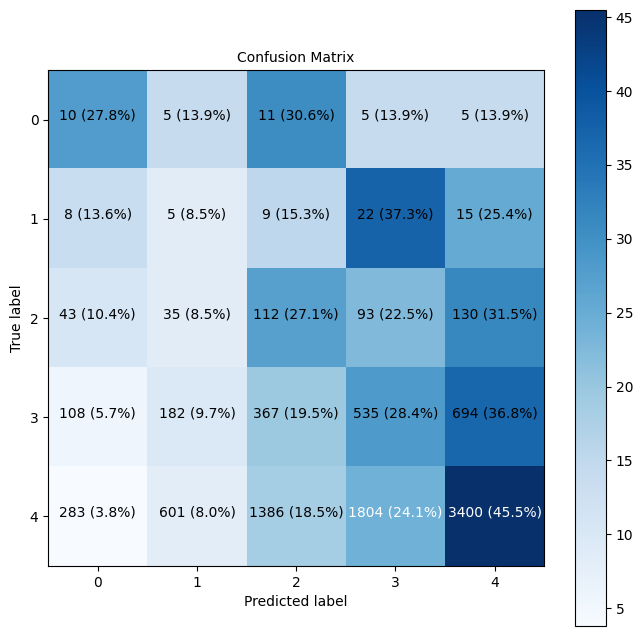

In [ ]:
plot_confusion_matrix(y_test, y_pred_test_dt)

**Detuning**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

encoder = ce.one_hot.OneHotEncoder()
sampler = RandomOverSampler(random_state=42)  # Implementing the oversampler
classifier = DecisionTreeClassifier(random_state=42)  # Removing class_weight parameter
param_grid = {
    'classifier__criterion': ['entropy'],
    'classifier__max_depth': [5, 10, 15],  # Reduced max depth
    'classifier__min_samples_split': [10, 20, 30],  # Increased min_samples_split
    'classifier__min_samples_leaf': [10, 20, 30],  # Increased min_samples_leaf
    'classifier__max_features': ['sqrt', 'log2']
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_dt = best_estimator.predict(X_train)
y_pred_test_dt = best_estimator.predict(X_test)
recall_train_dt = recall_score(y_train, y_pred_train_dt, average='macro')
recall_test_dt = recall_score(y_test, y_pred_test_dt, average='macro')

print("Recall Train:", recall_train_dt)
print("Recall Test:", recall_test_dt)

# Compute the confusion matrices
cm_train_dt = confusion_matrix(y_train, y_pred_train_dt)
cm_test_dt = confusion_matrix(y_test, y_pred_test_dt)




Fitting 5 folds for each of 54 candidates, totalling 270 fits
Recall Train: 0.4783545541611406
Recall Test: 0.3241043836356949


### **4.4) Random Forest:**

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = None
classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid = {
    'classifier__max_depth': [8],
    'classifier__min_samples_split': [5],
    'classifier__min_samples_leaf': [3],
    'classifier__max_features': ['log2']
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_rf = best_estimator.predict(X_train)
y_pred_test_rf = best_estimator.predict(X_test)
recall_train_rf = recall_score(y_train, y_pred_train_rf, average='macro')
recall_test_rf = recall_score(y_test, y_pred_test_rf, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_rf, recall_test_rf

(0.5667559015423433, 0.4522942505436081)

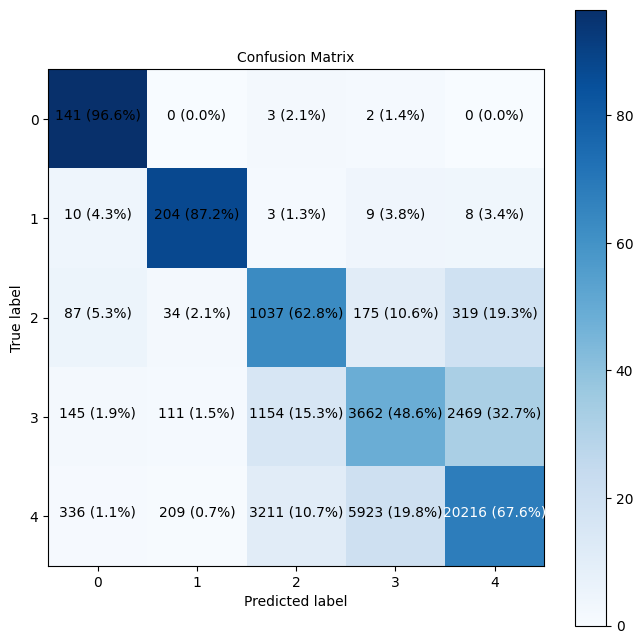

In [ ]:
plot_confusion_matrix(y_train, y_pred_train_rf)

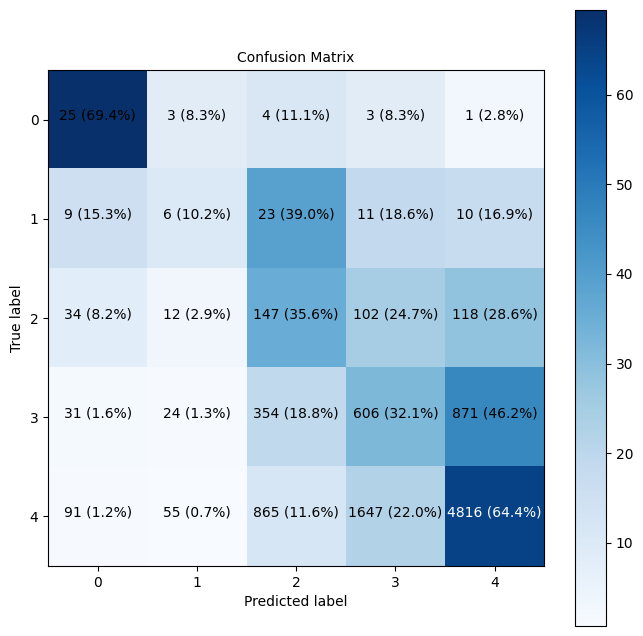

In [ ]:
plot_confusion_matrix(y_test, y_pred_test_rf)

Detuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

encoder = ce.one_hot.OneHotEncoder()
sampler = RandomOverSampler(random_state=42)  # Implementing the oversampler
classifier = RandomForestClassifier(random_state=42)  # Trying Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 15, 20],
    'classifier__min_samples_split': [10, 20],
    'classifier__min_samples_leaf': [10, 20],
    'classifier__max_features': ['sqrt', 'log2']
}
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_rf = best_estimator.predict(X_train)
y_pred_test_rf = best_estimator.predict(X_test)
recall_train_rf = recall_score(y_train, y_pred_train_rf, average='macro')
recall_test_rf = recall_score(y_test, y_pred_test_rf, average='macro')

print("Recall Train:", recall_train_rf)
print("Recall Test:", recall_test_rf)



Fitting 5 folds for each of 48 candidates, totalling 240 fits
Recall Train: 0.6298116930731461
Recall Test: 0.43639320041043234


In [ ]:

# Compute the confusion matrices
cm_train_rf = confusion_matrix(y_train, y_pred_train_rf)
cm_test_rf = confusion_matrix(y_test, y_pred_test_rf)



In [ ]:
# Plot confusion matrices
plot_confusion_matrix(cm_train_rf, title='Random Forest Confusion Matrix - Train Data')
plot_confusion_matrix(cm_test_rf, title='Random Forest Confusion Matrix - Test Data')

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = None
classifier = MLPClassifier()
param_grid = {
}
recall_train_mlp, recall_test_mlp, cm_train_mlp, cm_test_mlp = model(numeric_features, categorical_features, encoder, sampler, classifier, param_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
recall_train_mlp, recall_test_mlp

(0.713725618389317, 0.2629533195813969)

### **4.5) MLPClassifier:**

In [ ]:
# MLPClassifier
encoder = ce.one_hot.OneHotEncoder()
sampler = None
classifier = MLPClassifier()
param_grid = {
    'classifier__hidden_layer_sizes': [(100,)],  # example parameter, adjust as needed
    'classifier__activation': ['relu'],
    'classifier__solver': ['adam'],
    'classifier__alpha': [0.0001],
    'classifier__learning_rate': ['constant'],
}
# Create pipeline and fit model
pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_mlp = best_estimator.predict(X_train)
y_pred_test_mlp = best_estimator.predict(X_test)
recall_train_mlp = recall_score(y_train, y_pred_train_mlp, average='macro')
recall_test_mlp = recall_score(y_test, y_pred_test_mlp, average='macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# Print recall scores
print(f"Recall (train): {recall_train_mlp}")
print(f"Recall (test): {recall_test_mlp}")

Recall (train): 0.7178978520077853
Recall (test): 0.29665453350315996


In [ ]:
# Calculate confusion matrices
cm_train_mlp = confusion_matrix(y_train, y_pred_train_mlp)
cm_test_mlp = confusion_matrix(y_test, y_pred_test_mlp)

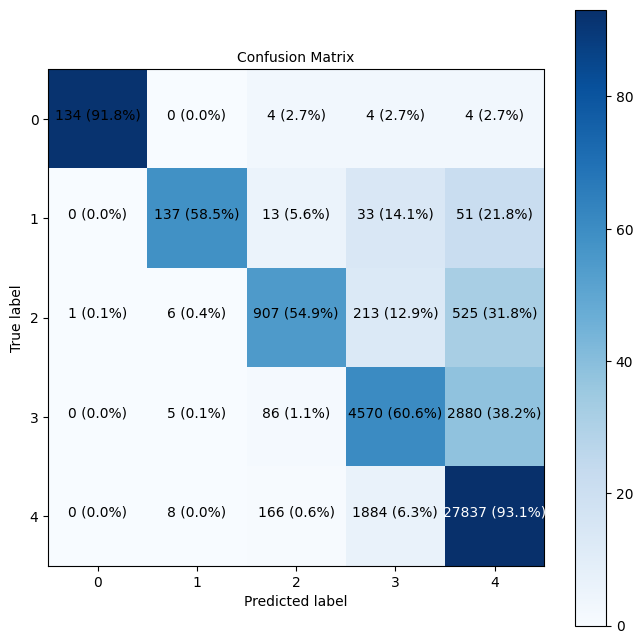

In [ ]:
# Plot confusion matrices
plot_confusion_matrix(cm_train_mlp)

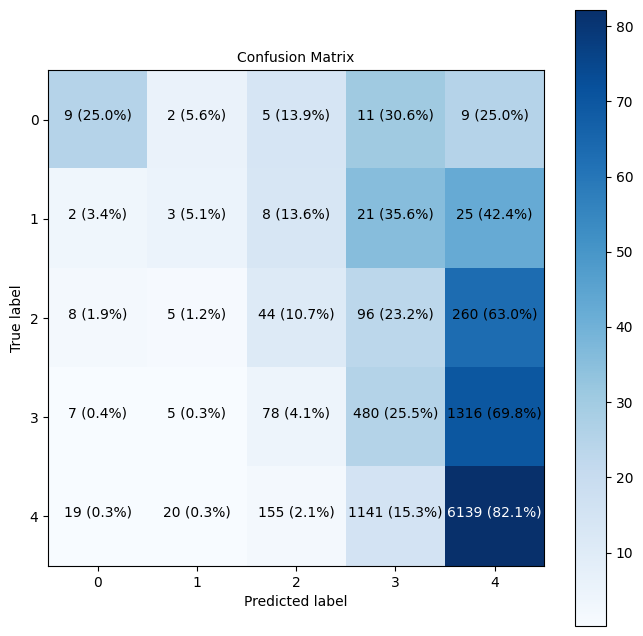

In [ ]:
plot_confusion_matrix(cm_test_mlp)

**Detuning**

In [ ]:
encoder = ce.one_hot.OneHotEncoder()
sampler = None
classifier = MLPClassifier(random_state=42)
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__early_stopping': [True],
    'classifier__batch_size': [32, 64, 128]
}

pipeline = pipe(numeric_features, categorical_features, encoder, sampler, classifier)
gcv = GridSearchCV(pipeline, param_grid, scoring=make_scorer(recall_score, average='macro'), cv=5, n_jobs=-1, verbose=1, error_score='raise')
gcv.fit(X_train, y_train)
best_estimator = gcv.best_estimator_
y_pred_train_mlp = best_estimator.predict(X_train)
y_pred_test_mlp = best_estimator.predict(X_test)
recall_train_mlp = recall_score(y_train, y_pred_train_mlp, average='macro')
recall_test_mlp = recall_score(y_test, y_pred_test_mlp, average='macro')




Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [ ]:
# Print recall scores
print(f"Recall (train): {recall_train_mlp}")
print(f"Recall (test): {recall_test_mlp}")

# Calculate confusion matrices
cm_train_mlp = confusion_matrix(y_train, y_pred_train_mlp)
cm_test_mlp = confusion_matrix(y_test, y_pred_test_mlp)



# 5) **Results:**

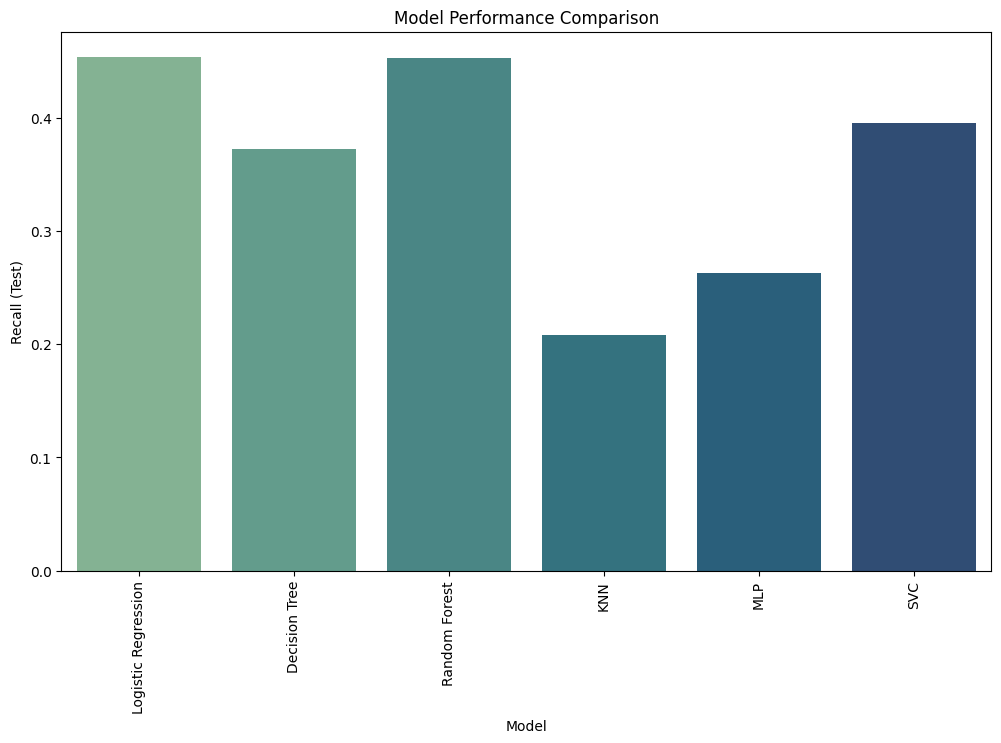

In [ ]:
# Example data for visualization
results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'MLP', 'SVC'],
    'Recall (Train)': [0.4701, 0.4580, 0.5668, 0.2311, 0.7137, 0.76978],
    'Recall (Test)': [0.4531, 0.3726, 0.4523, 0.2077, 0.2630, 0.39528]
}

results_df = pd.DataFrame(results)

# Plotting the performance comparison
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Recall (Test)', data=results_df, palette='crest')
plt.xticks(rotation=90)
plt.ylabel('Recall (Test)')
plt.title('Model Performance Comparison')
plt.show()